In [121]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score


In [27]:
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]
    pres_dict[v]['war'] = war[i]
print(pres_dict['bush'])

{'party': 'republican', 'war': 'war'}


In [68]:
## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

In [69]:
df.head()

,name,party,war,speech,title,date,text
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t..."
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...


In [70]:
def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inagural address', 'state of the union']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))
df.head()

,name,party,war,speech,title,date,text,interview,debate,inagural address,state of the union
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False


In [71]:
## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [72]:
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]

In [73]:
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False])

In [74]:
df[df['debate']==True]


,name,party,war,speech,title,date,text,interview,debate,inagural address,state of the union
5,bush,republican,war,"<title=""Debate with Bill Clinton and Ross Pero...",Debate with Bill Clinton and Ross Perot,"October 11, 1992","Well, I think one thing that distinguishes is...",False,True,False,False
13,bush,republican,war,"<title=""Debate with Michael Dukakis"">\n<date=""...",Debate with Michael Dukakis,"September 25, 1988",I think we've seen a deterioration of values....,False,True,False,False
23,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 6, 1976","Well, I think this Republican administration ...",False,True,False,False
26,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 22, 1976","Well, I might say first of all, that I think ...",False,True,False,False
28,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"September 23, 1976",Yes. First of all it's to recognize the treme...,False,True,False,False
41,carter,democrat,nw,"<title=""Debate with Ronald Reagan"">\n<date=""Oc...",Debate with Ronald Reagan,"October 28, 1980","Yes. \n\n Mr. Stone, I've had to make thousa...",False,True,False,False
60,clinton,democrat,nw,"<title=""Presidential Debate with Senator Bob D...",Presidential Debate with Senator Bob Dole,"October 6, 1996","Thank you, Jim, and thank you to the people o...",False,True,False,False
252,kennedy,democrat,war,"<title=""Debate with Richard Nixon in Washingto...","Debate with Richard Nixon in Washington, D. C.","October 7, 1960",In the first place I've never suggested that ...,False,True,False,False
253,kennedy,democrat,war,"<title=""Debate with Richard Nixon in New York ...",Debate with Richard Nixon in New York and Los ...,"October 13, 1960","Good evening, Mr. Shadel.\n\n Mr. McGee, we ...",False,True,False,False
260,kennedy,democrat,war,"<title=""Debate with Richard Nixon in New York""...",Debate with Richard Nixon in New York,"October 21, 1960","Good evening, Mr. Howe. \n\n Mr. Howe, Mr. V...",False,True,False,False


In [77]:
opponents = pd.DataFrame(data = opponents, columns = df.columns)
opponents.head()

,name,party,war,speech,title,date,text,interview,debate,inagural address,state of the union
0,clinton,democrat,0,0,0,0,The most important distinction in this campai...,False,True,False,False
1,dukakis,democrat,0,0,0,0,"Passionless? Peter, I care deeply about peop...",False,True,False,False
2,ford,republican,0,0,0,0,Governor Carter again is talking in broad gen...,False,True,False,False
3,ford,republican,0,0,0,0,"Mr. Kraft, I believe that the American people...",False,True,False,False
4,ford,republican,0,0,0,0,I don't believe that Mr. Carter has been any ...,False,True,False,False


In [79]:
df = pd.concat([df, opponents])

In [133]:
df[df['name']=='dole']

,name,party,war,speech,title,date,text,interview,debate,inagural address,state of the union
6,dole,republican,0,0,0,0,I think the basic difference is -- and I have...,False,True,False,False


## EDA 1

In [81]:
##EDA!!!

print(f'Speeches by president {df.name.value_counts()}')
print(f'speeches by party {df.party.value_counts()}')

Speeches by president lbjohnson      71
reagan         60
fdroosevelt    49
obama          48
kennedy        45
clinton        40
gwbush         39
hoover         29
nixon          27
bush           23
carter         22
truman         19
ford           17
eisenhower      6
mondale         2
dukakis         1
dole            1
Name: name, dtype: int64
speeches by party democrat      297
republican    202
Name: party, dtype: int64


In [82]:
#3/7 of presidents are classified as "not war" (Hoover, Eisenhower, Ford, Carter, Reagan, Clinton).  
#These presidents have a disproportionate number of 1 term presidents, so their share of speeches are roughly
#proportional to their time in office
print(df['war'].value_counts())
print(169/486, 3/7)

war    317
nw     169
0       13
Name: war, dtype: int64
0.3477366255144033 0.42857142857142855


In [83]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words='english', max_features=50)
X = count_vector.fit_transform(df.text)
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
labels = X.get_feature_names()
y_train = y_train.to_numpy()

## Initial Multinomial Bayes' run
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(f'Accuracy: {clf.score(X_test, y_test)}')
print(f'labels: {labels}')

ValueError: Shape of passed values is (499, 50), indices imply (499, 200)

In [34]:
### adding features up to 200
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
# %

## takes vectorized tokens, target values, and labels for the 
def MNB(vector_array, y, labels):
    BoW = pd.DataFrame(vector_array.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return (clf.predict(X_test), f'Accuracy: {clf.score(X_test, y_test)}')

print(MNB(X, df.party, labels))


(array(['republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'democrat', 'republican',
       'democrat', 'republican', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'democrat', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'republican', 'republican', 'democrat', 'republican', 'republican',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       

In [51]:
### adding features up to 200
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200, ngram_range = ((1,4)))
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' '

In [52]:
clf.classes_

array(['democrat', 'republican'], dtype='<U10')

In [53]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram
get_top_features(clf.feature_log_prob_, labels, 50)


(array(['national', 'free', 'hope', 'security', 'come', 'freedom', 'like',
        'need', 'long', 'say', 'right', 'way', 'future', 'going', 'good',
        'believe', 'let', 'help', 'mr', 'men', 'nations', 'united states',
        'great', 'today', 'americans', 'want', 've', 'congress',
        'applause', 'just', 'year', 'work', 'know', 'states', 'make',
        'government', 'peace', 'war', 'nation', 'think', 'united', 'time',
        'country', 'america', 'years', 'american', 'new', 'president',
        'world', 'people'], dtype='<U15'),
 array(['iraq', 'going', 'men', 'think', 'come', 'said', 'good', 'mr',
        'national', 'want', 'future', 'way', 'life', '000', 'free',
        'security', 'say', 'federal', 'economic', 'soviet', 'americans',
        'help', 'let', 'nations', 'today', 'year', 'work', 'just', 'make',
        'freedom', 'know', 'united states', 've', 'war', 'congress',
        'great', 'country', 'nation', 'time', 'years', 'united', 'states',
        'president', 

In [ ]:
print(f'Top words for democrats{np.array(labels)[last_5[:15]]}')
print(f'Top unique words for republicans{np.array(labels)[last_class_1[:15]]}')

In [ ]:
print(labels)

In [ ]:
### adding features up to 200, 3-grams, lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%

count_vector = CountVectorizer(max_features=200, ngram_range = ((1,4)), tokenizer=WordNetLemmatizer())
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [54]:
sw = stopwords.words('english')

In [49]:
## lemmatized

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
sw = stopwords.words('english')
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'republican' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'repu

In [43]:
zero, one, zero_uniqe, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero}')
print(f'one unique: {one}')

zero: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'war' 'every'
 'united' 'america' 'make' 'think' 'government' 'mr' 'new' "n't" 'must'
 'time' 'one' 'country' 'state' 'world' 'nation' 'u' 'would' 'president'
 'year' 'american' 'people' "'s" '--']
one: ['soviet' 'need' 'way' 'today' 'want' 'freedom' 'first' 'say' 'let'
 'force' 'well' 'think' 'right' 'every' 'work' 'tax' 'many' '``'
 'congress' 'great' 'life' "'re" 'make' 'united state' 'war' "''" 'know'
 'mr' "'ve" 'peace' 'united' 'country' 'new' "n't" 'time' 'must' 'america'
 'one' 'would' 'state' 'nation' 'president' 'government' 'world' 'year'
 'u' 'american' 'people' '--' "'s"]
zero unique: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'wa

In [55]:
stop = sw
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stop words

In [116]:
sw = stopwords.words('english')

new_sw = ['also', 'day','say', 'le', "'m", 'made', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [117]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## This is my main function

In [57]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['republican' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'democrat' 'democrat'
 'de

In [122]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,sw,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

def run_mnb(sw, text, y, ngrams = 3, max_features = 500):
    token_array = text.apply(lambda x: doc_to_tokens(x, sw))

    ## stores tokens in dictionary
    custom_tokens = {}
    for i,v in enumerate(token_array.to_numpy()):
        custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
    tfidf = TfidfVectorizer(
    # so we can pass it strings
        input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
        lowercase=False,
        preprocessor=lambda x: x,
        max_features = 700,
        ngram_range = ((1,3)),
    # use our token dictionary
        tokenizer=lambda key: custom_tokens[key])

    X = tfidf.fit_transform(custom_tokens.keys())
    labels = tfidf.get_feature_names()
# %%
    BoW = pd.DataFrame(X.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, score, labels, cvs



In [124]:
for i in range(5):
    clf, score, labels, cvs = run_mnb(sw, df['text'], df['party'])
    print(f'Cross val {i}: score {score}, cross val score {cvs}')


Cross val 0: score 0.784, cross val score 0.7379819819819818
Cross val 1: score 0.768, cross val score 0.7165765765765766
Cross val 2: score 0.712, cross val score 0.7352432432432432
Cross val 3: score 0.768, cross val score 0.7246126126126127
Cross val 4: score 0.792, cross val score 0.705945945945946


In [114]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'Dem: {zero}')
print(f'Rep: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

Dem: ['go' 'bill' 'power' 'national' 'well' 'problem' 'could' 'come' 'family'
 'security' 'q' 'free' 'effort' 'law' 'good' 'future' 'job' 'vietnam'
 'believe' 'need' 'hope' 'help' 'force' 'child' 'freedom' 'life'
 'congress' 'great' 'united state' 'want' 'work' 'make' 'know' 'right'
 'applause' 'government' 'america' 'time' 'united' 'think' 'new' 'state'
 'country' 'peace' 'president' 'war' 'world' 'nation' 'american' 'people']
Rep: ['business' 'citizen' 'want' 'could' 'hope' 'come' 'action' 'good' 'free'
 'law' 'future' 'national' 'tonight' 'system' 'child' 'security' 'vietnam'
 'help' 'need' 'well' 'right' 'economic' 'make' 'program' 'work'
 'united state' 'know' 'force' 'soviet' 'great' 'iraq' 'life' 'congress'
 'war' 'federal' 'freedom' 'united' 'president' 'country' 'tax' 'time'
 'new' 'peace' 'state' 'nation' 'america' 'government' 'world' 'american'
 'people']
Dem unique: ['go', 'bill', 'power', 'problem', 'family', 'q', 'effort', 'job', 'believe', 'applause', 'think']
Rep uniqu

In [130]:
feat = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
scores = []
for i in feat:
    _, score = run_mnb(max_features = feat)
    scores.append(score)
    

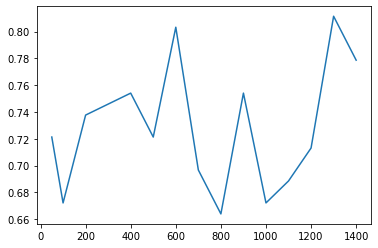

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)

In [129]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['problem' 'high' 'present' 'different' 'distinguished' 'goal' 'issue'
 'border' 'le' 'peaceful' 'congress' 'get' 'food' 'ensure'
 'fellow american' 'armed' 'economic growth' 'historic' 'even' 'better'
 "'ve" 'destruction' 'freedom' 'press' 'difficult' 'effective' 'candidate'
 'provide' 'giving' 'poor' 'greatest' 'financial' 'man' 'help' 'part'
 'education' 'ahead' 'agency' 'hope' 'information' 'political' 'path'
 'pressure' 'cause' 'job' 'needed' 'purpose' 'hemisphere' 'aggression'
 'instead']
one: ['ahead' 'policy' 'economic growth' 'help' 'different' 'abroad' 'food'
 'peaceful' 'get' 'high' 'present' 'better' 'men' 'official'
 'distinguished' 'historic' 'problem' 'man' 'ensure' 'kind' 'conduct'
 'federal' 'giving' 'financial' 'destruction' 'poor' 'provide' 'pressure'
 'freedom' 'effective' 'difficult' 'candidate' 'decision' 'opinion' "'re"
 'political' 'job' 'cause' 'much' 'path' "'ve" 'hope' 'information'
 'needed' 'hemisphere' 'education' 'agency' 'purpose' 'aggression'
 'in

## Scraping

In [126]:
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')


In [142]:
classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))
print(classes)

['page_item page-item-100', 'page_item page-item-102', 'page_item page-item-103', 'page_item page-item-104', 'page_item page-item-105', 'page_item page-item-106', 'page_item page-item-107', 'page_item page-item-108', 'page_item page-item-109', 'page_item page-item-110', 'page_item page-item-111', 'page_item page-item-112', 'page_item page-item-113', 'page_item page-item-114', 'page_item page-item-115', 'page_item page-item-116', 'page_item page-item-117', 'page_item page-item-119', 'page_item page-item-120', 'page_item page-item-123', 'page_item page-item-124', 'page_item page-item-125', 'page_item page-item-126', 'page_item page-item-128', 'page_item page-item-131', 'page_item page-item-133']


In [ ]:
print(soup.prettify())

In [ ]:
debate_names = [['kain', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
               ]

In [143]:
### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


for link in links:
    req = requests.get(link)
    soup = BeautifulSoup(req.content, 'html.parser')
    text = soup.get_text()

['',
 '',
 '',
 '',
 '',
 'CPD: October 21, 1960 Debate Transcript',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Home',
 'About CPD',
 'Debate History',
 'News',
 'DebateWatch',
 'Voter Education',
 'International',
 'Media',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'In This Section',
 '',
 '',
 'Debate Videos',
 'Debate Transcripts',
 '',
 'October 19, 2016 Debate Transcript',
 'October 9, 2016 Debate Transcript',
 'October 4, 2016 Debate Transcript',
 'September 26, 2016 Debate Transcript',
 'October 22, 2012 Debate Transcript',
 'October 16, 2012 Debate Transcript',
 'October 11, 2012 Debate Transcript',
 'October 3, 2012 Debate Transcript',
 'September 26, 2008 Debate Transcript',
 'October 2, 2008 Debate Transcript',
 'October 7, 2008 Debate Transcript',
 'October 15, 2008 Debate Transcript',
 'October 13, 2004 Debate Transcript',
 'October 8, 2004 Debate Transcript',
 'October 5, 2004 Transcript',
 'September 30, 2004 Debate Transcript',
 'October 17, 2000 Debat